In [75]:
from l1_m_tags import m_tags
import nltk
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_tags_master =  pd.read_csv("param_labels.csv")
df_videos = pd.read_csv("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/videos_eeuu.csv")
df_videos["Date"] = df_videos["publishedAt"].str.split("T", expand=True)[0]
df_comments = pd.read_csv("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/comments_eeuu.csv")
master_tags = pd.read_csv("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/l1/m_tags.csv")

In [118]:
df_videos["tags"] = df_videos.tags.str.split(",")
df_videos = df_videos.explode("tags")
lst_stopwords = nltk.corpus.stopwords.words("english")

df_videos["tags_clean"] = df_videos["tags"].apply(lambda text: clean_tags(
    text,
    flg_stemm=False,
    flg_lemm=True,
    lst_stopwords=lst_stopwords
))

def clean_tags(text, flg_stemm = False, flg_lemm=True, lst_stopwords = None):
    ## Clean (convert to lowercase and remove punctuation and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower())

    ## Tolenize (Convert from string to List)
    lst_text = text.split()

    ## Remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]


    ## Stemming (to remove -ly, -ing, etc.)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (Convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## Back to string from list
    text = " ".join(lst_text)
    return text

df_videos = df_videos.merge(master_tags[["tags_clean", "categorie"]], on="tags_clean", how="left")
df_videos = df_videos.loc[df_videos["categorie"].notna()]

In [ ]:
df_comments_aux = (
    df_comments[["video_id","comment_id" ,"author_id", "author_name", "test_display", "likes_count", "date_published"]].drop_duplicates()
    .merge(df_videos[["video_id","Date", "viewCount", "likeCount", "categorie"]].drop_duplicates(), 
    on="video_id", 
    how="left")
)

df_comments_aux["test_display_aux"] = df_comments_aux["test_display"].apply(lambda text: clean_tags(
    text,
    flg_stemm=False,
    flg_lemm=True,
    lst_stopwords=lst_stopwords
))

In [121]:
df_videos.to_parquet("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/l1/m_videos.parquet")

In [71]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jesustellez/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [73]:
res = {}
for i, row in df_comments_aux.iterrows():
    text = row["test_display_aux"]
    myid = row["comment_id"]
    res[myid] = sia.polarity_scores(text)

scores_aux = pd.DataFrame(res).T
scores_aux = scores_aux.reset_index().rename(columns={"index":"comment_id"})
scores_aux = df_comments_aux.merge(scores_aux, on="comment_id", how="left")

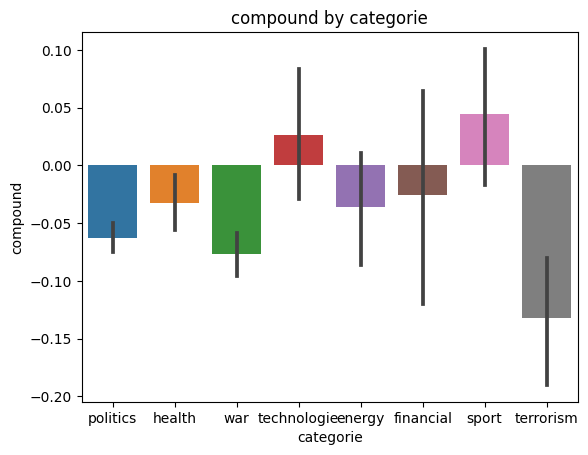

In [74]:
ax = sns.barplot(data = scores_aux, x = "categorie", y="compound")
ax.set_title("compound by categorie")
plt.show()

In [81]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

In [82]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

2022-10-09 17:04:15.583724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Downloading: 100%|██████████| 501M/501M [01:02<00:00, 7.97MB/s] 
2022-10-09 17:05:27.351540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is 

In [83]:
EXAMPLE = "your mother smells like my cat"
sia.polarity_scores(EXAMPLE)

{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.3612}

In [98]:
def tf_scores_polarity(text):
    
    encoded_text = tokenizer(text, return_tensors = "tf")
    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores_dict = {
        "tf_neg":scores[0],
        "tf_neu":scores[1],
        "tf_pos":scores[2]
    }
    return scores_dict

In [106]:
res = {}
for i, row in df_comments_aux.iterrows():
    try:
        text = row["test_display_aux"]
        myid = row["comment_id"]
        vader_results = sia.polarity_scores(text)
        vader_results_rename = {}
        for key, value in vader_results.items():
            vader_results_rename[f"vader_{key}"] = value

        roberta_results = tf_scores_polarity(text)
        scores = {**vader_results_rename, **roberta_results}
        res[myid] = scores
    except:
        print(f"error on {myid}")


error on UgxMjRCa7q92y8s9GAl4AaABAg
error on Ugwci0noKt2mPEeesc14AaABAg
error on Ugwci0noKt2mPEeesc14AaABAg
error on Ugwci0noKt2mPEeesc14AaABAg
error on UgyRnGOFEW2jTpv3FK94AaABAg
error on UgyRnGOFEW2jTpv3FK94AaABAg
error on UgxmHXWd_zHQnAvgKFt4AaABAg
error on UgxmHXWd_zHQnAvgKFt4AaABAg
error on UgxmHXWd_zHQnAvgKFt4AaABAg
error on Ugz1fKRMWemP3kgbMhV4AaABAg
error on Ugz1fKRMWemP3kgbMhV4AaABAg
error on Ugz1fKRMWemP3kgbMhV4AaABAg
error on Ugwempm-E__6nRTPttV4AaABAg
error on Ugwempm-E__6nRTPttV4AaABAg
error on UgzBBm9x7uEjiaoQM3p4AaABAg
error on UgyB9FVTU_Hn9xUaqBV4AaABAg
error on UgylHiMbZ6sX17-qbSF4AaABAg
error on Ugwui4v3m_VlOGzTR4N4AaABAg
error on Ugwfr_wbLCS6QGi18h14AaABAg
error on UgxoA2_Ef1-XTC9Ne3B4AaABAg
error on UgyjA8PkMZtstuuoQhR4AaABAg
error on Ugy7GonJ9B7NdqU845t4AaABAg
error on UgwCjf3JzNaspmJ86Dx4AaABAg
error on UgxdwjdJjQFH_Jl6Kwt4AaABAg
error on UgxECnKnE5wZ5kjIJt54AaABAg
error on UgxECnKnE5wZ5kjIJt54AaABAg
error on UgxwNDfOPu4wsyZeBX14AaABAg
error on UgwZ-z0ofOqxfK5YXFF

In [108]:
final_scores = pd.DataFrame(res).T
final_scores = final_scores.reset_index().rename(columns={"index":"comment_id"})
final_scores = df_comments_aux.merge(final_scores, on="comment_id", how="left")

In [116]:
final_scores.to_parquet("/Users/jesustellez/Desktop/aiDynamics/API Data extraction/Data/l1/fact_comments_rated.parquet")

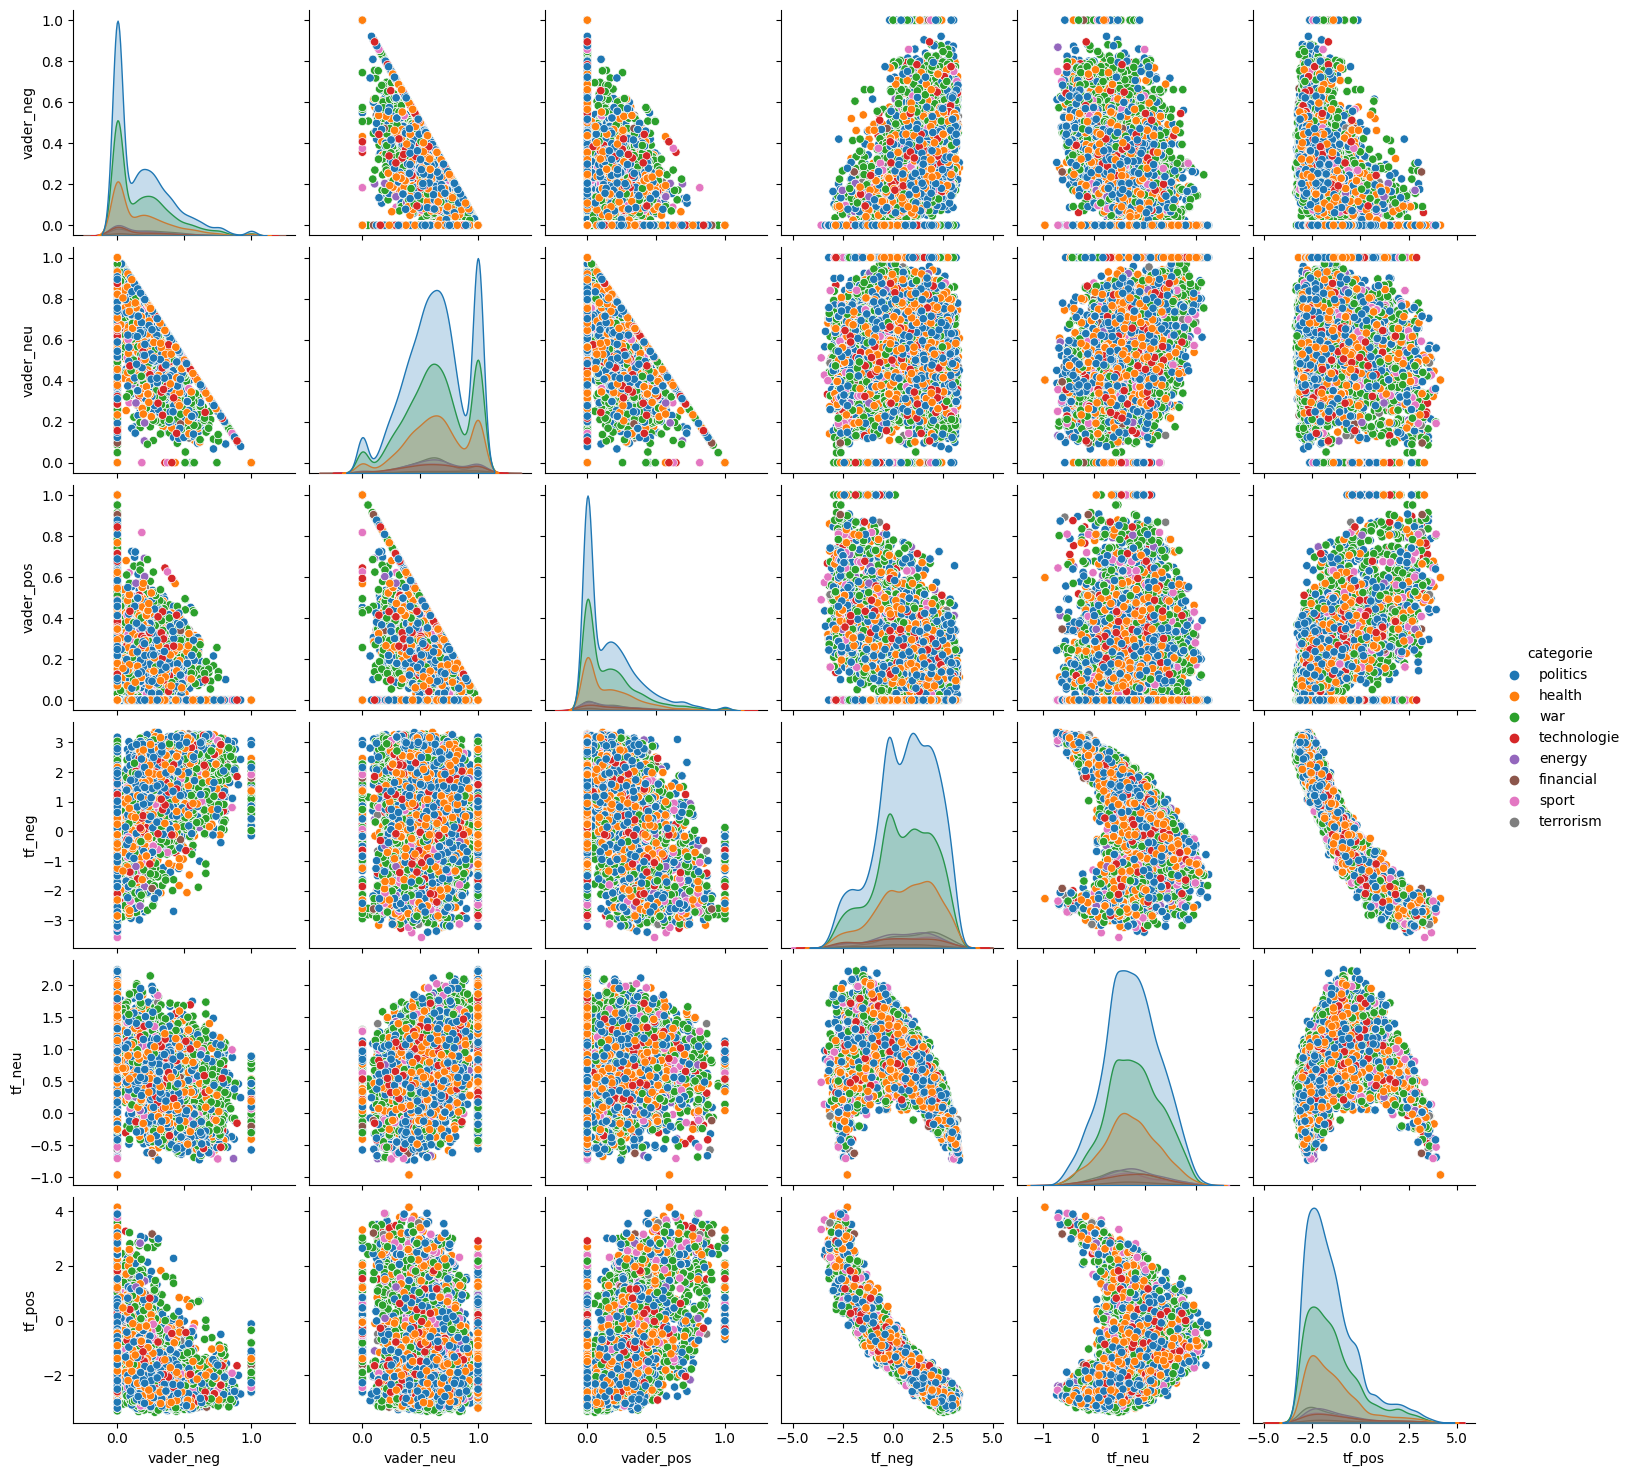

In [111]:
sns.pairplot(
    data = final_scores, 
    vars = ['vader_neg', 'vader_neu', 'vader_pos',
            'tf_neg', 'tf_neu', 'tf_pos'],
    hue="categorie",
    palette="tab10"
)
plt.show()

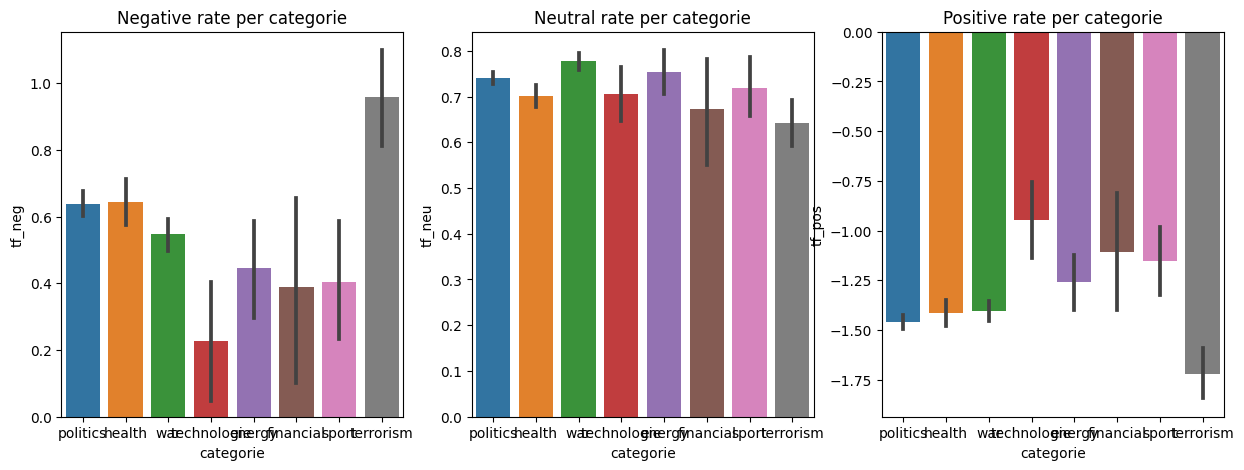

In [114]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data = final_scores, x = "categorie", y="tf_neg", ax = axs[0])
sns.barplot(data = final_scores, x = "categorie", y="tf_neu", ax = axs[1])
sns.barplot(data = final_scores, x = "categorie", y="tf_pos", ax = axs[2])
axs[0].set_title("Negative rate per categorie")
axs[1].set_title("Neutral rate per categorie")
axs[2].set_title("Positive rate per categorie")
plt.show()